In [3]:
import xarray as xr
import now
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
import dask as da
import scipy.stats as stats
from scipy.ndimage import label, generate_binary_structure
import time
from cartopy import config
import cartopy.crs as ccrs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: inproc://10.0.64.4/1679/1 Dashboard: http://localhost:39797/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [5]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futSev = xr.open_dataarray(localDir + 'severityMHWNOW_futRun.nc')
pastSev = xr.open_dataarray(localDir + 'severityMHWNOW_pastRun.nc')

## Finding max severity in future and past MHWs

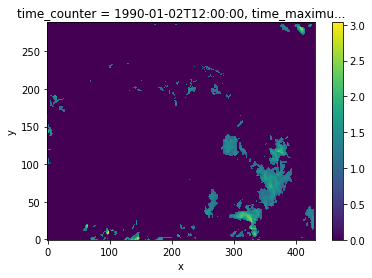

In [54]:
pastSev.isel(time_counter = 1).plot();

In [6]:
futSev = futSev.chunk({'x' : 200, 'y' : 200})
pastSev = pastSev.chunk({'x' : 200, 'y' : 200})

In [7]:
%%time 
maxFutSev = futSev.max(dim = 'time_counter').compute()

CPU times: user 6.06 s, sys: 13.7 s, total: 19.8 s
Wall time: 33.1 s


In [8]:
%%time 
maxPastSev = pastSev.max(dim = 'time_counter').compute()

CPU times: user 7.07 s, sys: 17.5 s, total: 24.5 s
Wall time: 37.7 s


In [9]:
# Replaces land masses with nan as opposed to 0 value
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)
maxFutSev = xr.where(maxFutSev == 0, np.nan, maxFutSev)

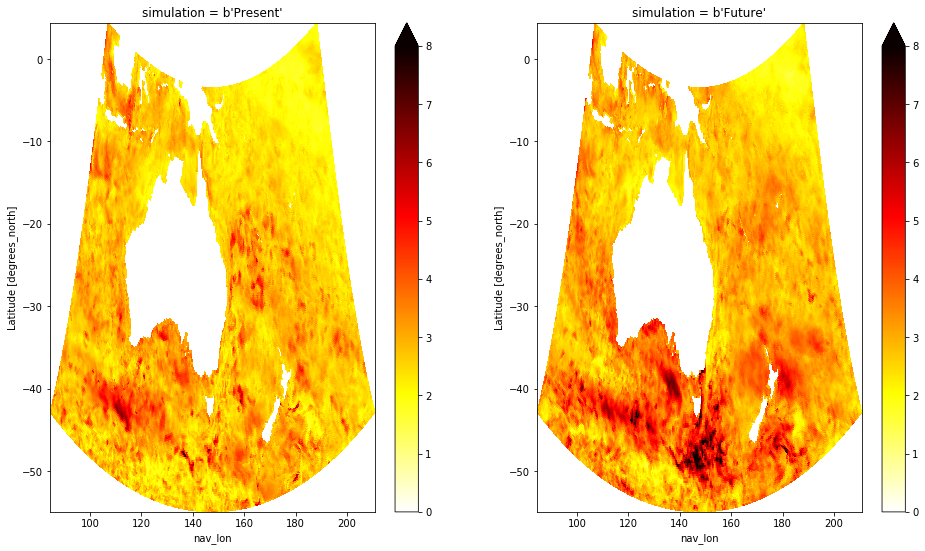

In [61]:
plt.rcParams["figure.figsize"] = [16,9]
vmin = 0; vmax = 8;
f, (ax1, ax2) = plt.subplots(1, 2)
maxPastSev.isel(x = slice(5,-5), y = slice(5,-50)).plot(cmap = 'hot_r', ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
maxFutSev.isel(x = slice(5,-5), y = slice(5,-50)).plot(cmap = 'hot_r',ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);

In [57]:
# Finding max SSTA - TO BE COMPLETED
ssta = sstFut.chunk({'x':50, 'y':50, 'time_counter':365}) - fClim.chunk({'x':50, 'y':50, 'time_counter':365})
maxFutSSTA = ssta.chunk({'x' : 200, 'y' : 200}).max(dim = 'time_counter').compute()
maxFutSSTA.isel(x = slice(5,-5), y= slice(5,-25)).plot(cmap = 'hot_r');

''

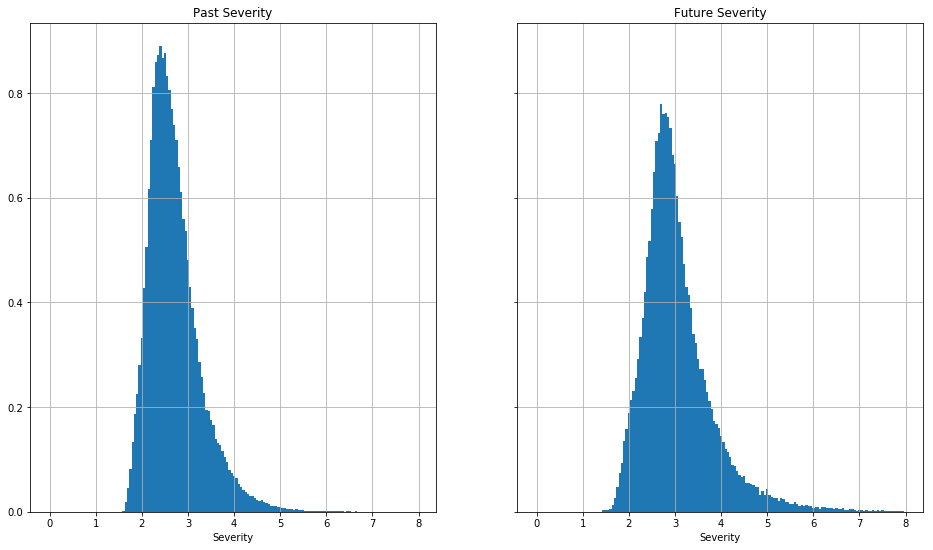

In [11]:
plt.rcParams["figure.figsize"] = [16,9]
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,8,161)

# True if plotting densities, false if you want just frequency
pltDens = True

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

maxPastSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Past', ax = ax1);
maxFutSev.plot.hist(align = 'left',  bins = bins, density = pltDens, label = 'Future', ax = ax2);
#plt.legend()


ax1.set_title('Past Severity')
ax1.grid(True)
ax1.set_xlabel('Severity')

ax2.set_title('Future Severity');
ax2.grid(True);
ax2.set_xlabel('Severity');
plt.savefig('/home/561/rm6294/Documents/maxFrequencyComparison2.png')
;

In [50]:
# Calculating interquartile range
past_iqr = (maxPastSev.quantile(q = 0.75) - maxPastSev.quantile(q = 0.25)).data
fut_iqr = (maxFutSev.quantile(q = 0.75) - maxFutSev.quantile(q = 0.25)).data

In [53]:
# Comparing statistics
print("Past: std =", np.round(maxPastSev.std().data, 2), ", var =", np.round(maxPastSev.var().data,2),
      ", mean =", np.round(maxPastSev.mean().data,2), ", median =", np.round(maxPastSev.median().data,2),
     ", iqr =", np.round(past_iqr, 2))
print("Futu: std =", np.round(maxFutSev.std().data, 2), ", var =", np.round(maxFutSev.var().data,2),
     ", mean =", np.round(maxFutSev.mean().data,2),  ", median =", np.round(maxFutSev.median().data,2),
     ", iqr =", np.round(fut_iqr, 2))

Past: std = 0.64 , var = 0.41 , mean = 2.74 , median = 2.63 , iqr = 0.67
Futu: std = 0.85 , var = 0.72 , mean = 3.1 , median = 2.93 , iqr = 0.81
